In [1]:
import os
import sys
print(sys.version)

from astropy import units as u
from astropy.io import fits
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

3.6.1 |Anaconda custom (x86_64)| (default, Mar 22 2017, 19:25:17) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
rawdir = os.path.expanduser('~/SuPrimeCam/SuPrimeCam_S17A-UH16A/o16308')


# Assembling an MEF

Each file has one chip with 4 channels.  Therefore we will generate a 40 extension MEF, one extension per channel.  This allows for different properties in each channel (i.e. gain) to be accounted for.

In [3]:
def assemble_MEF(file0, write=False):
    path, filename0 = os.path.split(file0)
    files = ['{}{:d}.fits'.format(filename0[0:11], n) for n in range(0,10)]
    rawhduls = [fits.open(os.path.join(rawdir, file), 'readonly') for file in files]
    expid0 = rawhduls[0][0].header.get('EXP-ID')

    # Confirm that EXP-IDs match indicating that these files are from the same exposure
    for hdul in rawhduls:
        expid = hdul[0].header.get('EXP-ID')
        if not expid == expid0:
            print(f'WARNING: EXP-ID mismatch!! {expid0}, {expid}')
    
    # Split each file out in to channels and assemble a multi extension fits (MEF)
    # file from the individual amplifiers (4 per chip)
    MEF = fits.HDUList([])
    extver = 0
    for i,hdul in enumerate(rawhduls):
        detid = hdul[0].header.get('DET-ID')
        detx = hdul[0].header.get('DET-P101')
        dety = hdul[0].header.get('DET-P201')
        chxpos = []
        chypos = []
        minyos = {}
        minyef = {}
        minxos = {}
        minxef = {}
        maxyos = {}
        maxyef = {}
        maxxos = {}
        maxxef = {}

        for ch in [1,2,3,4]:
            minxos[ch] = hdul[0].header.get(f'S_OSMN{ch}1')
            maxxos[ch] = hdul[0].header.get(f'S_OSMX{ch}1')
            minyos[ch] = hdul[0].header.get(f'S_OSMN{ch}2')
            maxyos[ch] = hdul[0].header.get(f'S_OSMX{ch}2')

            minxef[ch] = hdul[0].header.get(f'S_EFMN{ch}1')
            maxxef[ch] = hdul[0].header.get(f'S_EFMX{ch}1')
            minyef[ch] = hdul[0].header.get(f'S_EFMN{ch}2')
            maxyef[ch] = hdul[0].header.get(f'S_EFMX{ch}2')
            chxpos.append(minxef[ch])
            chypos.append(minyef[ch])

        minxpix = min(chxpos)
        minypix = min(chypos)
        tb = {True: 2, False: 1}[dety > -30]
        DETSECy2 = tb * (maxyef[1] - minypix)
        DETSECy1 = DETSECy2 - (maxyef[1] - minyef[1]) + 1

        for ch in [1,2,3,4]:
            extver += 1
            miny = min([minyos[ch], minyef[ch]])
            minx = min([minxos[ch], minxef[ch]])
            maxy = max([maxyos[ch], maxyef[ch]])
            maxx = max([maxxos[ch], maxxef[ch]])
            chdata = hdul[0].data[miny:maxy,minx:maxx]
            if extver == 1:
                phdu = fits.PrimaryHDU(None, hdul[0].header)
                MEF.append(phdu)
            chhdu = fits.ImageHDU(chdata, hdul[0].header, name=f'd{detid}c{ch}')
            chhdu.header.set('EXTNAME', f'im{extver}')
            chhdu.header.set('EXTVER', extver)
            chhdu.header.set('IMAGEID', f'd{detid}c{ch}')
            chhdu.header.set('CCDNAME', hdul[0].header.get('DETECTOR'))
            binx = int(hdul[0].header.get('BIN-FCT1'))
            biny = int(hdul[0].header.get('BIN-FCT2'))
            chhdu.header.set('CCDSUM', f'{binx:d} {biny:d}')
            chhdu.header.set('FILTER', hdul[0].header.get('FILTER01'))
            # OBSTYPE: "zero", "dark", flat", and "object"
            obstype_trans = {'DOMEFLAT': 'flat', 'SKYFLAT': 'twiflat',
                             'BIAS': 'zero', 'OBJECT': 'object', 'DARK': 'dark'}
            obstype = obstype_trans[hdul[0].header.get('DATA-TYP').strip()]
            chhdu.header.set('OBSTYPE', obstype)

            BIASSECx1 = minxos[ch] - minx + 1
            BIASSECx2 = maxxos[ch] - minx
            BIASSECy1 = minyef[ch] - miny + 1
            BIASSECy2 = maxyef[ch] - miny
            biassec = f'[{BIASSECx1:d}:{BIASSECx2:d},{BIASSECy1:d}:{BIASSECy2:d}]'
            chhdu.header.set('BIASSEC', biassec)

            DATASECx1 = minxef[ch] - minx + 1
            DATASECx2 = maxxef[ch] - minx
            DATASECy1 = minyef[ch] - miny + 1
            DATASECy2 = maxyef[ch] - miny
            datasec = f'[{DATASECx1:d}:{DATASECx2:d},{DATASECy1:d}:{DATASECy2:d}]'
            chhdu.header.set('DATASEC', datasec)

            print(biassec, datasec)
            detsecy = {True: 2, False: 1}[dety > 0]
            ampwidth = maxxef[ch] - minxef[ch]
            chipwidth = 4 * ampwidth
            if detx > 30:
                DETSECx1 = 4 * chipwidth + (maxxef[ch] - ampwidth - minxef[ch] % ampwidth) + 1
            elif detx > 0:
                DETSECx1 = 3 * chipwidth + (maxxef[ch] - ampwidth - minxef[ch] % ampwidth) + 1
            elif detx > -30:
                DETSECx1 = 2 * chipwidth + (maxxef[ch] - ampwidth - minxef[ch] % ampwidth) + 1
            elif detx > -60:
                DETSECx1 = 1 * chipwidth + (maxxef[ch] - ampwidth - minxef[ch] % ampwidth) + 1
            else:
                DETSECx1 = 0 * chipwidth + (maxxef[ch] - ampwidth - minxef[ch] % ampwidth) + 1
            DETSEXx2 = DETSECx1 + ampwidth -1
            chhdu.header.set('DETSEC', f'[{DETSECx1:d}:{DETSEXx2:d},{DETSECy1:d}:{DETSECy2:d}]')
            MEF.append(chhdu)
    return MEF


In [4]:
filename = 'SUPA01564270.fits'
MEF = assemble_MEF(os.path.join(rawdir, filename))
MEF.writeto(filename.replace('SUPA', 'MEF_'), overwrite=True)

[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[1:47,1:4176] [49:559,1:4176]
[513:559,1:4176] [1:511,1:4176]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]
[1:47,49:4224] [49:559,49:4224]
[513:559,49:4224] [1:511,49:4224]


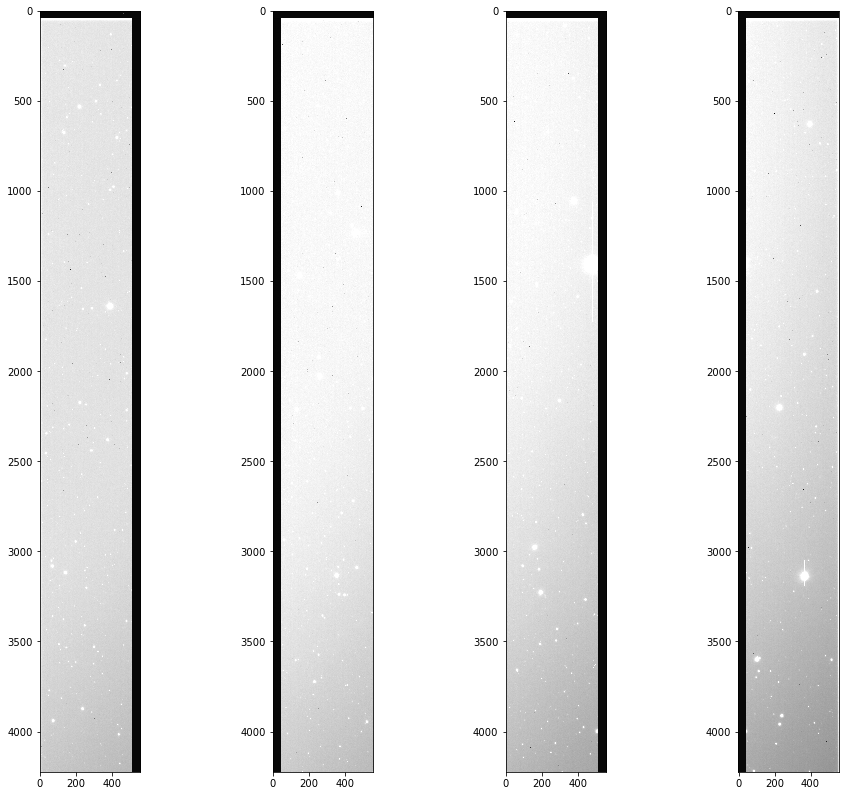

In [5]:
plt.figure(figsize=(16,14))

for i,hdu in enumerate(MEF[1:5]):
    plt.subplot(1,4,i+1)
    vmin = np.percentile(hdu.data, 0.75)
    vmax = np.percentile(hdu.data, 98.5)
    plt.imshow(hdu.data, vmin=vmin-100, vmax=vmax)

plt.show()